<a href="https://colab.research.google.com/github/hockijo/PNMR-Data/blob/main/ossc_import_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.signal as scisig
import scipy.optimize as optimize
from scipy.fft import fft 
import numpy.fft as npfft
url='https://raw.githubusercontent.com/hockijo/PNMR-Data/main'

In [ ]:
def osscPlot(file, directory=(url+"/osscimports/data")):
    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float) #dropping labels and setting all data to be floats
    
    fig,ax=plt.subplots()
    for column in data_clean.columns[1:]:
        ax.plot(data_clean["x-axis"], data_clean[column],label=column)
    ax.legend()
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Voltage(V)")
    plt.show(fig)
    #plt.savefig(directory+file[:-4]+".png") commented all saves for this upload

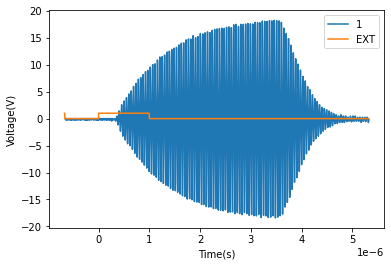

In [ ]:
i=0
osscPlot(f"/scope_{i}.csv")    

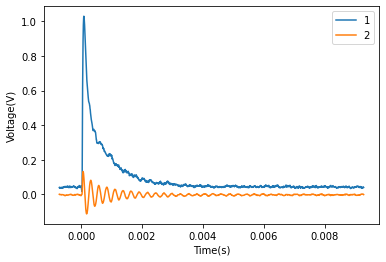

In [ ]:
i=1
osscPlot(f"/scope_{i}.csv")    

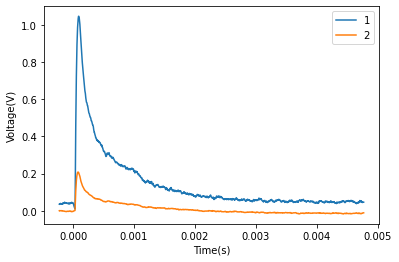

In [ ]:
i=2
osscPlot(f"/scope_{i}.csv")    

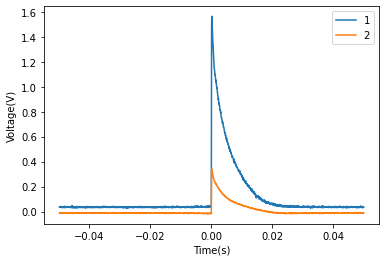

In [ ]:
i=3
osscPlot(f"/scope_{i}.csv")    

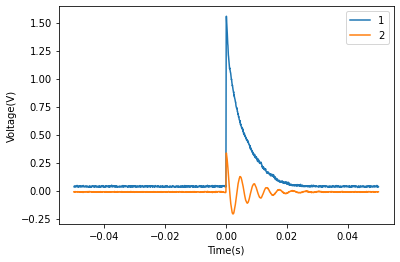

In [ ]:
i=4
osscPlot(f"/scope_{i}.csv")    

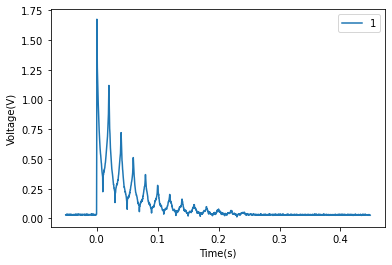

In [ ]:
i=134
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

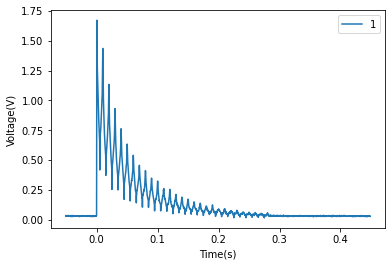

In [ ]:
i=135
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

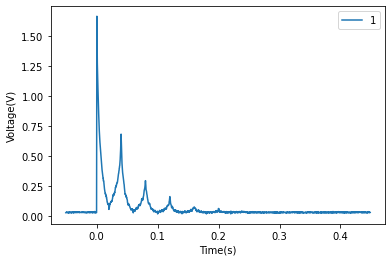

In [ ]:
i=136
osscPlot(f"/scope_{i}.csv",directory=url+'/T2/data')   

In [ ]:
def getExpDecay(scope_number):
    directory=url+"/T2"
    file=f"/data/scope_{scope_number}.csv"

    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)

    #this finds the index of the peaks using the scipy.signal package, the prominence defines how the peaks should compare to the rest of the data
    peak_indexes=scisig.find_peaks(data_clean['1'].values, prominence=0.05)[0] 
    #prominence could be decreased to examine tail peaks,
    #however somtimes it leads to finding false peaks

    peaks=data_clean.iloc[peak_indexes].reset_index(drop=True) #getting the value of the peaks

    #below is the model fit, the model is defined using lambda calculus, the data is the list of peaks (x-axis and chan 1 respectively) and p0 are the initial values for the parameters
    parameters,cv = optimize.curve_fit(lambda t,M,T,c:M*np.exp(t*T)+c, peaks['x-axis'], peaks['1'],p0=(1.6,-20,0.08))
    M,T,c = parameters[0],parameters[1], parameters[2] #extracting the parameters out of the list given by fit
    decay_fit = M*np.exp(data_clean['x-axis'][peak_indexes[0]:]*T)+c #the model evaluated and the x-axis recorded by ossc

    fig,ax =plt.subplots()
    ax.plot(data_clean['x-axis'],data_clean['1'],label='Data') #data from ossc, blue plot
    ax.plot(peaks['x-axis'],peaks['1'],'.r',label='Peaks') # peak locations, shown as red dots
    ax.plot(data_clean['x-axis'][peak_indexes[0]:], decay_fit,'--',label='Fit') #the model fit in orange
    ax.legend()
    plt.text(0.35,1.25,f"T2={-1/T*10**3:.3f}ms") #printing the value for T2
    ax.set_xlabel("Time(s)")
    ax.set_ylabel("Voltage(V)")

    #plt.savefig(directory+file[:-4]+"T2.png")
    plt.show()
    
    lines=[f'M={M}',f'T={T}',f'c={c}',f'Model is M*exp(T*t)+c']
    #with open(directory+file[:-4]+"_parameters.csv",'w') as f:
        #for line in lines:
            #f.write(line+"\n")

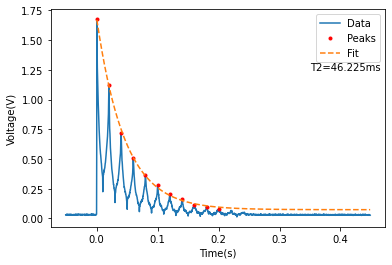

In [ ]:
getExpDecay(134)

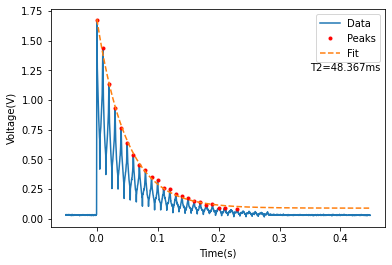

In [ ]:
getExpDecay(135)

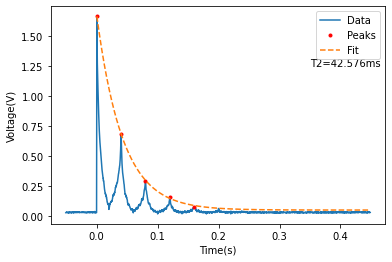

In [ ]:
getExpDecay(136)

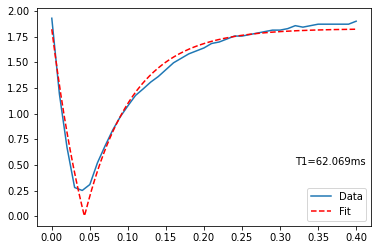

In [ ]:
directory=url+"/T1-decay%20data"

peak_times=np.linspace(0.0001,0.4001,41) #this is tau
peak_volts=[]
#a for loop for opening the csv files, pulling the max value and appending that to a list. This could be improved as it sometimes reads Pulse A when
#the value for pulse B is lower than it.
for i in range(5,46):
    file= f"/data/scope_{i}.csv"
    data = pd.read_csv(directory+file)
    data_clean=data.drop(labels=0).astype(float)
    peak_index=data_clean["1"].idxmax()
    #peak_times.append(data_clean["x-axis"][peak_index])
    peak_volts.append(data_clean["1"][peak_index])
    #print(i,data_clean["1"][peak_index])

#there is an outlier with data point 28, I beleive the ossciloscope did not pick up the signal from pulse B, 
#instead my code would be taking a second from the following period 180d pulse as the max. Hence I am excluding this data point.


#plt.scatter(peak_times,peak_volts)

dDict={"Time": peak_times,"Volts": peak_volts} #could imporve efficiency by writing drictly to dict
peaks=pd.DataFrame.from_dict(dDict)
peaks_clean=peaks.drop(28)

minimum_index=peaks_clean['Volts'].idxmin()
rising=peaks_clean.iloc[minimum_index+1:] #as there is a slight ramp up when rising, i avoid that by +1 index to purely get an expontial curve to fit

parameters, cv = optimize.curve_fit(lambda t,a,b:np.abs(a*(1-2*np.exp(b*t))), peaks_clean['Time'], peaks_clean['Volts'],p0=(1.8,-15)) #cv contains info like std error
a,b = parameters[0],parameters[1]#,parameters[2]
rise_fit = np.abs(a*(1-2*np.exp(b*np.linspace(peaks_clean['Time'][0],peaks_clean['Time'].iloc[-1],300))))

#print(f"T1={-1/b*10**3:.3f}ms")

fig,ax=plt.subplots()
ax.plot(peaks_clean['Time'],peaks_clean['Volts'],label='Data')
ax.plot(np.linspace(peaks_clean['Time'][0],peaks_clean['Time'].iloc[-1],300),rise_fit,'--r',label='Fit')
ax.legend()
plt.text(0.32,0.5,f"T1={-1/b*10**3:.3f}ms")

plt.show()
#plt.savefig(directory+"/graphT1.png")

lines=[f'a={a}',f'b={b}',f'Model is ABS(a*(1-2))']#,f'c={c}'
#with open(directory+"/T1_parameters-edited.csv",'w') as f:
    #for line in lines:
        ##f.write(line+"\n")

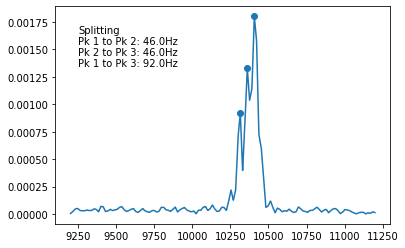

In [ ]:
directory=url+"/Spectrometer"
file="/scope_1.csv"

data = pd.read_csv(directory+file)
data_trace=data.iloc[0:2001].drop(labels=0).astype(float)
data_fft=data.iloc[2002:].drop(labels=2002).astype(float)

fft_peak_indexes=scisig.find_peaks(data_fft['1'].values, prominence=0.0001)[0]
peak_lst=data_fft['x-axis'].iloc[fft_peak_indexes].values
v_peak_lst=data_fft['1'].iloc[fft_peak_indexes].values

fig,ax=plt.subplots()
plt.text(9250,0.00175-0.0001,f'Splitting')
plt.text(9250,0.00175-0.0002,f'Pk 1 to Pk 2: {peak_lst[1]-peak_lst[0]:.1f}Hz')
plt.text(9250,0.00175-0.0003,f'Pk 2 to Pk 3: {peak_lst[2]-peak_lst[1]:.1f}Hz')
plt.text(9250,0.00175-0.0004,f'Pk 1 to Pk 3: {peak_lst[2]-peak_lst[0]:.1f}Hz')
#for i in range(0,len(fft_peak_indexes)):
    #plt.text(9250,0.00175-0.0001*i,f'From pk {i}: {((peak_lst[i])/(21.29*10**6))*10**6:.1f} ppm')#trouble caluclating this ppm
ax.scatter(data_fft['x-axis'].iloc[fft_peak_indexes],data_fft['1'].iloc[fft_peak_indexes],marker='o')
ax.plot(data_fft['x-axis'],data_fft['1'])

plt.show()

#print(f'The frequency differences are {}')

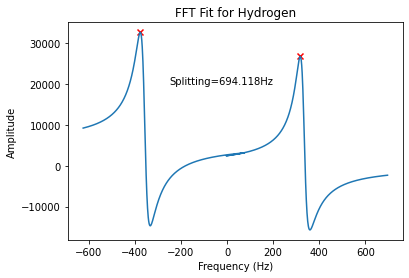

In [13]:
import requests as req

#url = “https://raw.githubusercontent.com/hockijo/PNMR-Data/main”
res = req.get(url+'/SPINQ%20Data/FIDH-1.txt')
lines=res.text.splitlines()
#data = pd.read_csv('SPINQ Data\FIDH-1.txt',sep='\n')
#lines = open('SPINQ Data\FIDH-1.txt').read().splitlines()
data_FID=pd.DataFrame(columns=range(1,4))
n=0
for n in range(0,4):
    if lines[n] == 'H':
        continue
    #line_split=line.split(") (")
    lines[n]=lines[n][8:]
    lines[n]=lines[n][:-1]
    data_FID.loc[:,n]=lines[n].split(") (")
    
data_FID_Time=data_FID[1].str.split(',',expand=True).loc[:,0]
for col in data_FID:
    data_FID[col]=data_FID[col].str.split(',',expand=True).loc[:,1]

data_FID=pd.concat([data_FID_Time,data_FID],axis=1).astype(float)
data_FID=data_FID.iloc[:4000,:]
#plt.plot(data_FID[0],data_FID.loc[:,1:3])


data_FFT_RE=pd.Series(lines[4][8:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_IM=pd.Series(lines[5][8:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_MOD=pd.Series(lines[6][9:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_FIT=pd.Series(lines[7][9:-1].split(") (")).str.split(',',expand=True).astype(float)

fft_fit_peaks_idx=list(scisig.find_peaks(data_FFT_FIT[1].values,prominence=5000)[0])
fft_fit_peaks=data_FFT_FIT.loc[np.subtract(fft_fit_peaks_idx,1),:].reset_index(drop=True)

splitting=fft_fit_peaks.loc[1,0]-fft_fit_peaks.loc[0,0]

fig,ax=plt.subplots()
ax.plot(data_FFT_FIT[0],data_FFT_FIT[1])
ax.scatter(fft_fit_peaks[0],fft_fit_peaks[1],color='r',marker='x')
plt.text(-250,20000,f'Splitting={splitting:.3f}Hz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
plt.title('FFT Fit for Hydrogen')

plt.show()

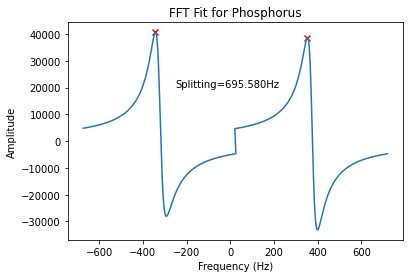

In [14]:
#data = pd.read_csv('SPINQ Data\FIDH-1.txt',sep='\n')
res = req.get(url+'/SPINQ%20Data/FIDP-1.txt')
lines=res.text.splitlines()
data_FID=pd.DataFrame(columns=range(1,4))
n=0
for n in range(0,4):
    if lines[n] == 'P':
        continue
    #line_split=line.split(") (")
    lines[n]=lines[n][8:]
    lines[n]=lines[n][:-1]
    data_FID.loc[:,n]=lines[n].split(") (")
    
data_FID_Time=data_FID[1].str.split(',',expand=True).loc[:,0]
for col in data_FID:
    data_FID[col]=data_FID[col].str.split(',',expand=True).loc[:,1]

data_FID=pd.concat([data_FID_Time,data_FID],axis=1).astype(float)
data_FID=data_FID.iloc[:4000,:]
#plt.plot(data_FID[0],data_FID.loc[:,1:3])


data_FFT_RE=pd.Series(lines[4][8:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_IM=pd.Series(lines[5][8:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_MOD=pd.Series(lines[6][9:-1].split(") (")).str.split(',',expand=True).astype(float)
data_FFT_FIT=pd.Series(lines[7][9:-1].split(") (")).str.split(',',expand=True).astype(float)

fft_fit_peaks_idx=list(scisig.find_peaks(data_FFT_FIT[1].values,prominence=5000)[0])
fft_fit_peaks=data_FFT_FIT.loc[np.subtract(fft_fit_peaks_idx,1),:].reset_index(drop=True)

splitting=fft_fit_peaks.loc[1,0]-fft_fit_peaks.loc[0,0]

fig,ax=plt.subplots()
ax.plot(data_FFT_FIT[0],data_FFT_FIT[1])
ax.scatter(fft_fit_peaks[0],fft_fit_peaks[1],color='r',marker='x')
plt.text(-250,20000,f'Splitting={splitting:.3f}Hz')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
plt.title('FFT Fit for Phosphorus')

plt.show()